In [1]:
using Printf, CSV, DataFrames, Statistics, Glob, XLSX, Dates, Plots, TimeSeries, JSON, Distributions

In [ ]:
data_directory = joinpath(homedir(), "research", "GADS_Processed", "raw_data")
files = glob("gen_*_type_*_dtgrp_*_rating_*_state_Texas_raw.csv", data_directory)

142-element Vector{String}:
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_1_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_2_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_1_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_2_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_1_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_2_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_2_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_3_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 26 bytes ⋯ "ST_rating_3_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 27 bytes ⋯ "ST_rating_3_state_Texas_raw.csv"
 ⋮
 "/home/emco4286/research/GADS_Pr" ⋯ 26 bytes ⋯ "ST_rating_2_state_Texas_raw.csv"
 "/home/emco4286/research/GADS_Pr" ⋯ 26 bytes ⋯ "ST_rating_2_state_

In [ ]:
gen_ids = unique(merged[!, "UnitID"])
merged.CommercialDT_grp = missings(Int, nrow(merged))
merged.RatingMW_grp = missings(Int, nrow(merged))
merged.StateName = missings(String, nrow(merged))

myDict = Dict()

for u in gen_ids

    my_unit = filter(:UnitID => ==(u), units)
    subset = @view merged[(merged.UnitID .== u), :]

    commercial_dt_grp = my_unit[1, :CommercialDT_grp]
    subset.CommercialDT_grp .= commercial_dt_grp

    rating = my_unit[1, :RatingMW_grp]
    subset.RatingMW_grp .= rating

    state = my_unit[1, :StateName]
    subset.StateName .= state 

    unit_type_code = subset[1, :UnitTypeCode]

    # val = units[units.UnitID .== u, :CommercialDT_grp][1]
    # vec = merged[merged.UnitID .== u, :CommercialDT_grp]
    # new_vec = fill(val, length(vec))
    # merged[merged.UnitID .== u, :CommercialDT_grp] = new_vec

    # val = units[units.UnitID .== u, :RatingMW_grp][1]
    # vec = merged[merged.UnitID .== u, :RatingMW_grp]
    # new_vec = fill(val, length(vec))
    # merged[merged.UnitID .== u, :RatingMW_grp] = new_vec

    # val = units[units.UnitID .== u, :StateName][1]
    # vec = merged[merged.UnitID .== u, :StateName]
    # new_vec = fill(val, length(vec))
    # merged[merged.UnitID .== u, :StateName] = new_vec

    fname = @sprintf "gen_%d_type_%d_dtgrp_%d_rating_%d_state_%s_raw.csv" u unit_type_code commercial_dt_grp rating state
    path = joinpath(homedir(), "research", "GADS_Processed", "raw_data", fname)
    CSV.write(path, subset)

end

In [22]:
num_fo_vec = Any[]
foh_vec = Any[]

num_po_vec = Any[]
poh_vec = Any[]

num_mo_vec = Any[]
moh_vec = Any[]

for f in files

    df = DataFrame(CSV.File(f))

    years = round(df.x[end] - df.x[begin], Day).value/365

    if size(df)[1] < 1

        push!(foh_vec, 0)
        push!(num_fo_vec, 0)

        push!(poh_vec, 0)
        push!(num_po_vec, 0)

        push!(moh_vec, 0)
        push!(num_mo_vec, 0)

        continue
    end

    outage_start = findall(diff(df[!, :y1]) .== -1)
    outage_end = findall(diff(df[!, :y1]) .== 1)

    if length(outage_end) < length(outage_start)
        outage_start = outage_start[begin: end-1]
    elseif length(outage_end) > length(outage_start)
        outage_end = outage_end[begin + 1: end]
    end

    ttr_values = outage_end .- outage_start
    ttf_values_all_types = outage_start[begin + 1: end] - outage_end[begin:end - 1]

    outage_types = df[outage_end, :y2]
    
    fo_idx = findall(outage_types .== 2)

    num_fo_average = length(fo_idx)/years
    foh_average = sum(ttr_values[fo_idx])/years

    push!(foh_vec, foh_average)
    push!(num_fo_vec, num_fo_average)

    po_idx = findall(outage_types .== 3)
    num_po_average = length(po_idx)/years
    poh_average = sum(ttr_values[po_idx])/years

    push!(poh_vec, poh_average)
    push!(num_po_vec, num_po_average)

    mo_idx = findall(outage_types .== 4)
    
    num_mo_average = length(mo_idx)/years
    moh_average = sum(ttr_values[mo_idx])/years

    push!(moh_vec, moh_average)
    push!(num_mo_vec, num_mo_average)

end

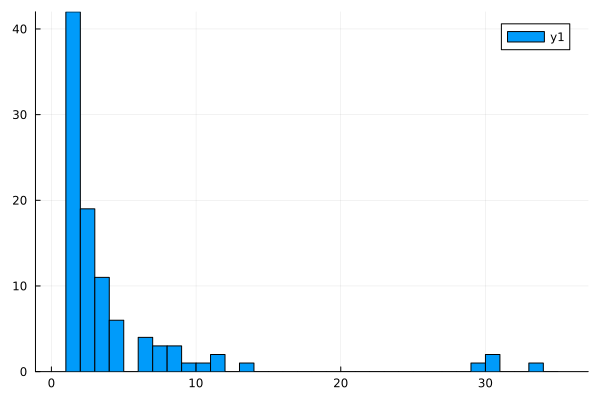

In [23]:
histogram(num_mo_vec, bins=1:1:35)

In [24]:
findall(x->x==maximum(num_mo_vec), num_mo_vec)

1-element Vector{Int64}:
 77

In [5]:
@printf "Average number of FO/ year: %.3f\n" mean(num_fo_vec)
@printf "Average number of PO/ year: %.3f\n" mean(num_po_vec)
@printf "Average number of MO/ year: %.3f\n" mean(num_mo_vec)

Average number of FO/ year: 15.346
Average number of PO/ year: 1.565
Average number of MO/ year: 3.156


In [6]:
@printf "Average number of FOH/ year: %.3f hours\n" mean(foh_vec)
@printf "Average number of POH/ year: %.3f hours\n" mean(poh_vec)
@printf "Average number of MOH/ year: %.3f hours\n" mean(moh_vec)

Average number of FOH/ year: 1040.743 hours
Average number of POH/ year: 749.633 hours
Average number of MOH/ year: 267.714 hours


In [7]:
@printf "Average number of hours per FO: %.3f hours\n" mean(foh_vec)/mean(num_fo_vec)
@printf "Average number of hours per PO: %.3f hours\n" mean(poh_vec)/mean(num_po_vec)
@printf "Average number of hours per MO: %.3f hours\n" mean(moh_vec)/mean(num_mo_vec)

Average number of hours per FO: 67.820 hours
Average number of hours per PO: 478.939 hours
Average number of hours per MO: 84.837 hours


In [25]:
f = files[77]
df = DataFrame(CSV.File(f))

years = round(df.x[end] - df.x[begin], Day).value/365

outage_start = findall(diff(df[!, :y1]) .== -1)
outage_end = findall(diff(df[!, :y1]) .== 1)


161-element Vector{Int64}:
   120
   269
   437
   605
   774
   940
  1014
  1021
  1127
  1299
     ⋮
 26979
 27145
 27313
 27482
 27655
 27998
 28320
 28488
 28771

In [27]:
f

"/home/emco4286/research/GADS_Processed/st/gen_495_class_ST_rating_3_state_Texas_raw.csv"

In [26]:
df[outage_start .+ 1, :]

Row,x,y1,y2,y3,y9,ERCOT,y4,Pcp,Tmax,Tmin,y6,y7,y8
,DateTime,Float64,Float64,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Int64?,Int64?,Int64
1,2013-01-05T06:00:00,0.0,3.0,10231,3.0,34105.2,5,2.46,59.4,36.4,missing,missing,1
2,2013-01-12T08:00:00,0.0,4.0,10238,3.0,27478.0,12,2.46,59.4,36.4,6,missing,1
3,2013-01-19T08:00:00,0.0,4.0,10245,3.0,36645.6,19,2.46,59.4,36.4,13,7,1
4,2013-01-26T08:00:00,0.0,4.0,10252,3.0,29524.7,26,2.46,59.4,36.4,20,7,1
5,2013-02-02T08:00:00,0.0,4.0,10259,3.0,30939.8,33,1.21,64.9,38.4,27,7,2
6,2013-02-09T07:00:00,0.0,4.0,10266,3.0,27859.9,40,1.21,64.9,38.4,34,7,2
7,2013-02-12T02:00:00,0.0,2.0,10269,3.0,27222.9,43,1.21,64.9,38.4,37,3,2
8,2013-02-12T17:00:00,0.0,2.0,10270,3.0,33615.0,43,1.21,64.9,38.4,38,3,2
9,2013-02-16T18:00:00,0.0,2.0,10274,3.0,29140.7,47,1.21,64.9,38.4,42,7,2
